# Analisis de Cobertura Forestal en Yolombo, Antioquia

## Contexto del Proyecto

Este proyecto tiene como objetivo analizar el estado actual del paisaje forestal del municipio de Yolombo, Antioquia, Colombia, mediante el uso de imagenes satelitales y tecnicas de inteligencia artificial. El analisis busca identificar:

- **Zonas con cobertura boscosa conservada**: Areas donde persisten ecosistemas forestales naturales
- **Areas abiertas o transformadas**: Zonas donde ha ocurrido conversion del uso del suelo
- **Patrones de fragmentacion**: Distribucion espacial y conectividad del bosque
- **Indicadores de degradacion**: Senales de presion sobre el ecosistema forestal

## Justificacion

El municipio de Yolombo se ubica en una region de importancia ecologica en Antioquia, donde la presion antropogenica (agricultura, ganaderia, expansion urbana) ha modificado historicamente el paisaje natural. Comprender el estado actual de la cobertura forestal es fundamental para:

1. La planificacion territorial sostenible
2. La conservacion de la biodiversidad local
3. La identificacion de areas prioritarias para restauracion
4. El monitoreo de servicios ecosistemicos (agua, carbono, regulacion climatica)

## Metodologia General

El proyecto integra dos componentes tecnologicos principales:

### 1. Procesamiento Geografico (QGIS)
- Descarga y carga de imagenes satelitales del territorio de Yolombo
- Delimitacion precisa del area municipal
- Division del territorio en una cuadricula regular (tiles)
- Exportacion de cada tile como imagen PNG individual

### 2. Analisis Computacional (Python)
- Calculo de indices de vegetacion basados en bandas RGB
- Extraccion de estadisticas descriptivas por tile
- Segmentacion mediante algoritmos de Machine Learning (K-Means)
- Clasificacion de tipos de cobertura
- Analisis de patrones espaciales y fragmentacion
- Generacion de visualizaciones y mapas tematicos

## Alcance y Limitaciones

**Alcance**: Este analisis proporciona una evaluacion cuantitativa del estado actual del paisaje forestal de Yolombo, permitiendo identificar patrones de distribucion de la cobertura y areas con potencial degradacion.

**Limitaciones**: 
- No incluye comparacion temporal (multitemporal)
- Los indices RGB son aproximaciones; idealmente se usarian bandas espectrales NIR
- La resolucion espacial depende de la imagen satelital fuente
- Requiere validacion en campo para mayor precision

---

## 1. Configuracion del Entorno y Carga de Datos

En esta seccion importamos las bibliotecas necesarias y cargamos los tiles previamente generados desde QGIS.

**Bibliotecas utilizadas:**
- `cv2` (OpenCV): Procesamiento de imagenes
- `numpy`: Operaciones numericas y matrices
- `pandas`: Manipulacion y analisis de datos tabulares
- `sklearn`: Algoritmos de machine learning (K-Means)
- `matplotlib` y `seaborn`: Visualizacion de datos
- `scipy`: Operaciones cientificas avanzadas

In [1]:
!pip install opencv-python-headless numpy pandas scikit-learn matplotlib seaborn scipy

In [2]:
# Importar librerias necesarias
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos de visualizacion
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Definir ruta a los tiles
tiles_path = r'C:\YolomboProject\Code\tiles\*.png'
tiles = glob.glob(tiles_path)

print(f"Total de tiles encontrados: {len(tiles)}")
print(f"Ejemplo de tiles:")
for i, tile in enumerate(tiles[:5]):
    print(f"  {i+1}. {os.path.basename(tile)}")

Total de tiles encontrados: 69
Ejemplo de tiles:
  1. tile_0.png
  2. tile_1.png
  3. tile_10.png
  4. tile_11.png
  5. tile_12.png


### Verificacion de dimensiones y calidad de tiles

Es importante verificar que todos los tiles tengan las mismas dimensiones y que las imagenes se hayan cargado correctamente.

In [3]:
# Verificar dimensiones de los tiles
dimensions = []
for tile in tiles[:10]:  # Revisar primeros 10 tiles
    img = cv2.imread(tile)
    if img is not None:
        dimensions.append(img.shape)

# Comprobar consistencia
unique_dims = set(dimensions)
print(f"Dimensiones unicas encontradas: {unique_dims}")
if len(unique_dims) == 1:
    print(f"Todos los tiles tienen dimensiones consistentes: {dimensions[0]}")
    print(f"  - Alto: {dimensions[0][0]} pixeles")
    print(f"  - Ancho: {dimensions[0][1]} pixeles")
    print(f"  - Canales: {dimensions[0][2]} (BGR)")
else:
    print("ADVERTENCIA: Los tiles tienen dimensiones inconsistentes")

Dimensiones unicas encontradas: {(2480, 3507, 3)}
Todos los tiles tienen dimensiones consistentes: (2480, 3507, 3)
  - Alto: 2480 pixeles
  - Ancho: 3507 pixeles
  - Canales: 3 (BGR)


## 2. Indices de Vegetacion Basados en RGB

Los indices de vegetacion son transformaciones matematicas de las bandas espectrales que permiten realzar la presencia de vegetacion. Aunque lo ideal seria usar bandas infrarrojas (NIR), podemos aproximar algunos indices usando solo RGB:

### Indices implementados:

1. **VARI (Visible Atmospherically Resistant Index)**
   - Formula: `(Verde - Rojo) / (Verde + Rojo - Azul)`
   - Util para evaluar la fraccion de vegetacion verde

2. **GLI (Green Leaf Index)**
   - Formula: `(2*Verde - Rojo - Azul) / (2*Verde + Rojo + Azul)`
   - Enfatiza la reflectancia verde caracteristica de hojas sanas

3. **ExG (Excess Green Index)**
   - Formula: `2*Verde - Rojo - Azul`
   - Resalta areas con predominancia de pigmentos verdes

4. **NGRDI (Normalized Green-Red Difference Index)**
   - Formula: `(Verde - Rojo) / (Verde + Rojo)`
   - Version original implementada en el notebook

In [4]:
# Definir funciones para calcular multiples indices de vegetacion

def calculate_ngrdi(img):
    """Normalized Green-Red Difference Index"""
    green = img[:,:,1].astype(float)
    red = img[:,:,2].astype(float)
    return (green - red) / (green + red + 1e-5)

def calculate_vari(img):
    """Visible Atmospherically Resistant Index"""
    green = img[:,:,1].astype(float)
    red = img[:,:,2].astype(float)
    blue = img[:,:,0].astype(float)
    return (green - red) / (green + red - blue + 1e-5)

def calculate_gli(img):
    """Green Leaf Index"""
    green = img[:,:,1].astype(float)
    red = img[:,:,2].astype(float)
    blue = img[:,:,0].astype(float)
    return (2*green - red - blue) / (2*green + red + blue + 1e-5)

def calculate_exg(img):
    """Excess Green Index"""
    green = img[:,:,1].astype(float)
    red = img[:,:,2].astype(float)
    blue = img[:,:,0].astype(float)
    return 2*green - red - blue

# Calcular estadisticas para cada tile
stats = []
for tile in tiles:
    img = cv2.imread(tile)
    if img is None:
        continue
    
    # Calcular indices
    ngrdi = calculate_ngrdi(img)
    vari = calculate_vari(img)
    gli = calculate_gli(img)
    exg = calculate_exg(img)
    
    # Extraer estadisticas
    stats.append({
        'tile': os.path.basename(tile),
        'ngrdi_mean': float(ngrdi.mean()),
        'ngrdi_std': float(ngrdi.std()),
        'ngrdi_max': float(ngrdi.max()),
        'vari_mean': float(vari.mean()),
        'vari_std': float(vari.std()),
        'gli_mean': float(gli.mean()),
        'exg_mean': float(exg.mean()),
        'green_mean': float(img[:,:,1].mean()),
        'red_mean': float(img[:,:,2].mean()),
        'blue_mean': float(img[:,:,0].mean()),
        'brightness': float(img.mean()),
    })

df = pd.DataFrame(stats)
print(f"Estadisticas calculadas para {len(df)} tiles")
df.head(10)

Estadisticas calculadas para 69 tiles


tile  ngrdi_mean  ngrdi_std  ngrdi_max     vari_mean       vari_std  \
0   tile_0.png    0.214365   0.166673        1.0   9095.171755  115272.224136   
1   tile_1.png    0.203753   0.173013        1.0   7513.190015  104708.756456   
2  tile_10.png    0.282904   0.179002        1.0  16352.748174  171350.082276   
3  tile_11.png    0.275928   0.173499        1.0  15789.691945  162515.968953   
4  tile_12.png    0.216065   0.146453        1.0   6224.630982   99779.801076   
5  tile_13.png    0.161615   0.140144        1.0   4570.936061   86821.472492   
6  tile_14.png    0.226016   0.162408        1.0   8802.013045  127442.110296   
7  tile_15.png    0.246682   0.176187        1.0  16746.098902  165274.813682   
8  tile_16.png    0.274778   0.177516        1.0  23112.012083  196546.493139   
9  tile_17.png    0.289519   0.165971        1.0  26200.120306  216402.684727   

   gli_mean   exg_mean  green_mean   red_mean  blue_mean  brightness  
0  0.081522  19.462636   64.194506  48.093520  60.832855   57.706960  
1  0.085916  20.375955   66.620436  50.638583  62.226332   59.828450  
2  0.079144  20.470181   63.216642  41.285365  64.677738   56.393249  
3  0.080054  19.204709   58.705333  38.061833  60.144123   52.303763  
4  0.092801  23.206854   70.109877  50.309296  66.703604   62.374259  
5  0.080297  21.378054   71.870506  56.724442  65.638515   64.744488  
6  0.092918  23.432270   67.985654  48.356649  64.182390   60.174898  
7  0.037642  11.473616   58.609725  41.222551  64.523283   54.785186  
8  0.025784   8.974412   52.920011  35.284890  61.580720   49.928540  
9  0.048039  12.006686   52.477322  32.941892  60.006066   48.475093

### Visualizacion de indices de vegetacion en tiles de ejemplo

Visualicemos como se ven los diferentes indices en algunos tiles representativos.

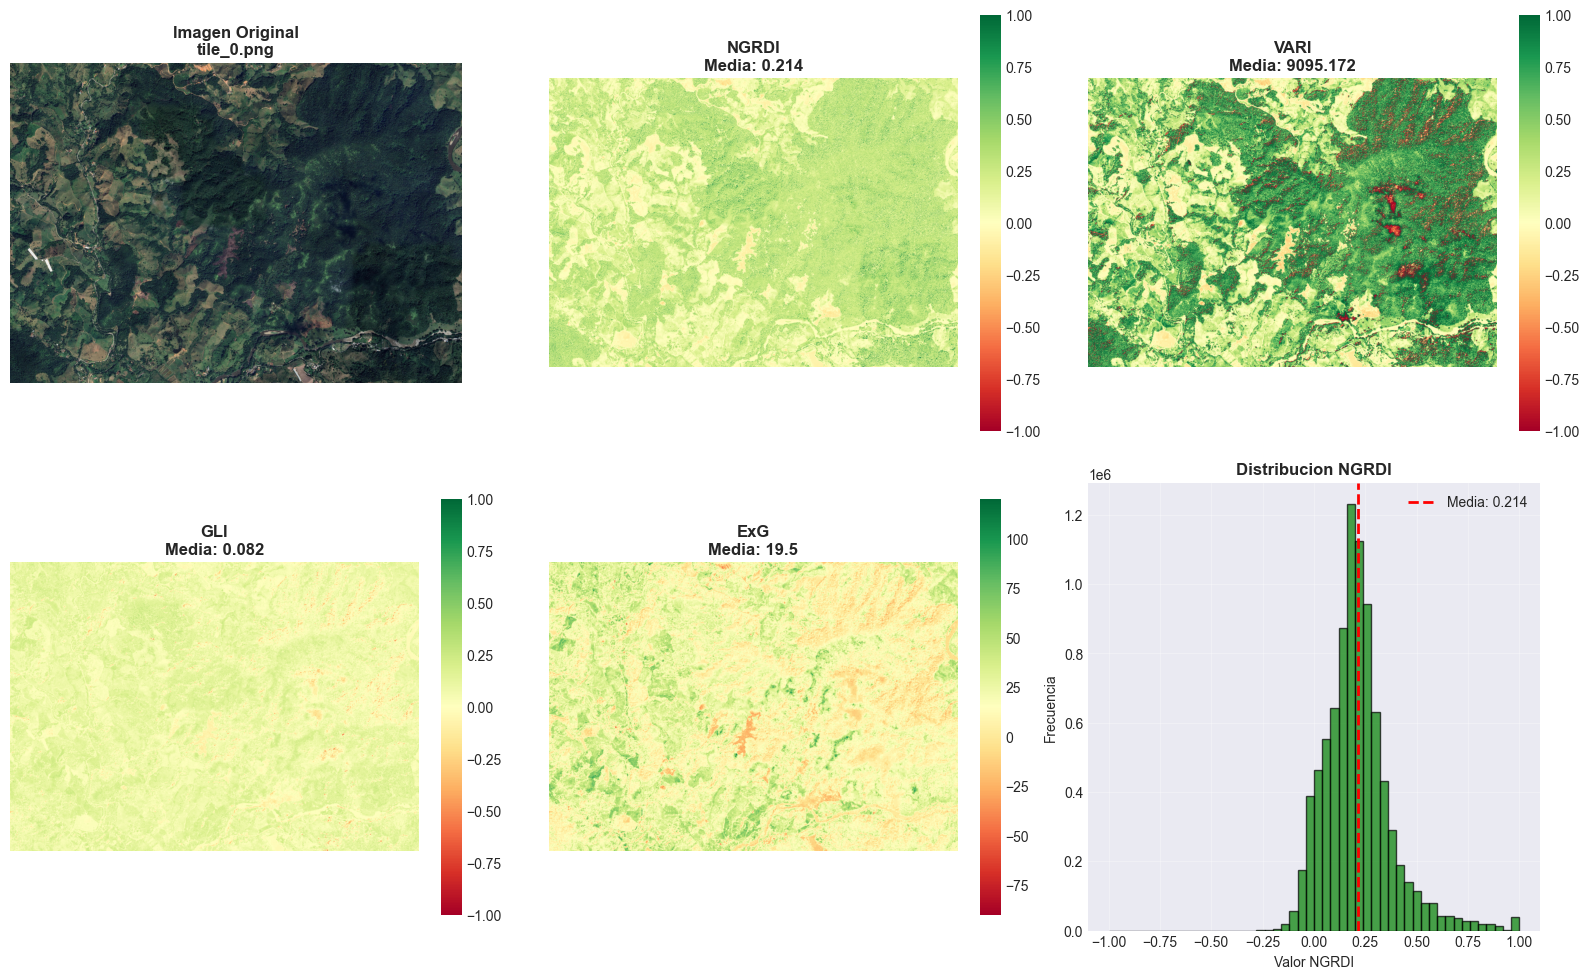

Interpretacion:
- Valores altos (verdes): Mayor presencia de vegetacion
- Valores bajos (rojos): Areas con menor vegetacion (suelo, construcciones, agua)
- NGRDI y VARI entre 0.2-0.6 indican vegetacion saludable


In [5]:
# Visualizar indices en un tile de ejemplo
if len(tiles) > 0:
    sample_img = cv2.imread(tiles[0])
    
    # Calcular indices
    ngrdi = calculate_ngrdi(sample_img)
    vari = calculate_vari(sample_img)
    gli = calculate_gli(sample_img)
    exg = calculate_exg(sample_img)
    
    # Crear visualizacion
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Imagen original
    axes[0, 0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(f'Imagen Original\n{os.path.basename(tiles[0])}', fontsize=12, weight='bold')
    axes[0, 0].axis('off')
    
    # NGRDI
    im1 = axes[0, 1].imshow(ngrdi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0, 1].set_title(f'NGRDI\nMedia: {ngrdi.mean():.3f}', fontsize=12, weight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)
    
    # VARI
    im2 = axes[0, 2].imshow(vari, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0, 2].set_title(f'VARI\nMedia: {vari.mean():.3f}', fontsize=12, weight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)
    
    # GLI
    im3 = axes[1, 0].imshow(gli, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1, 0].set_title(f'GLI\nMedia: {gli.mean():.3f}', fontsize=12, weight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046)
    
    # ExG
    im4 = axes[1, 1].imshow(exg, cmap='RdYlGn')
    axes[1, 1].set_title(f'ExG\nMedia: {exg.mean():.1f}', fontsize=12, weight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046)
    
    # Histograma NGRDI
    axes[1, 2].hist(ngrdi.flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Distribucion NGRDI', fontsize=12, weight='bold')
    axes[1, 2].set_xlabel('Valor NGRDI')
    axes[1, 2].set_ylabel('Frecuencia')
    axes[1, 2].axvline(ngrdi.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {ngrdi.mean():.3f}')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Interpretacion:")
    print("- Valores altos (verdes): Mayor presencia de vegetacion")
    print("- Valores bajos (rojos): Areas con menor vegetacion (suelo, construcciones, agua)")
    print("- NGRDI y VARI entre 0.2-0.6 indican vegetacion saludable")

## 3. Analisis Estadistico Exploratorio

Analicemos la distribucion de los indices de vegetacion a traves de todos los tiles para identificar patrones generales del paisaje.

In [6]:
# Guardar estadisticas
df.to_csv('yolombo_stats.csv', index=False)
print("Archivo 'yolombo_stats.csv' guardado exitosamente.\n")

# Estadisticas descriptivas detalladas
print("="*60)
print("ESTADISTICAS DESCRIPTIVAS DEL PAISAJE DE YOLOMBO")
print("="*60)
print("\nIndices de Vegetacion:")
print(df[['ngrdi_mean', 'vari_mean', 'gli_mean', 'exg_mean']].describe().round(3))

print("\n" + "="*60)
print("Bandas Espectrales RGB:")
print(df[['red_mean', 'green_mean', 'blue_mean', 'brightness']].describe().round(2))

Archivo 'yolombo_stats.csv' guardado exitosamente.

ESTADISTICAS DESCRIPTIVAS DEL PAISAJE DE YOLOMBO

Indices de Vegetacion:
       ngrdi_mean  vari_mean  gli_mean  exg_mean
count      69.000     69.000    69.000    69.000
mean        0.231  14288.526     0.074    20.764
std         0.091   9367.556     0.027     6.811
min        -0.101     -0.921     0.007     2.116
25%         0.204   7781.038     0.058    18.657
50%         0.256  14157.048     0.077    21.085
75%         0.286  20367.086     0.085    24.799
max         0.374  49416.782     0.165    34.731

Bandas Espectrales RGB:
       red_mean  green_mean  blue_mean  brightness
count     69.00       69.00      69.00       69.00
mean      50.94       72.23      72.76       65.31
std       10.59       13.30      17.08       12.11
min       30.65       46.89      33.41       45.23
25%       45.94       64.19      62.23       56.49
50%       49.61       71.86      74.08       65.05
75%       54.76       80.79      83.86       72.03
m

### Visualizacion de distribuciones

Grafiquemos la distribucion de los indices de vegetacion para entender la heterogeneidad del paisaje.

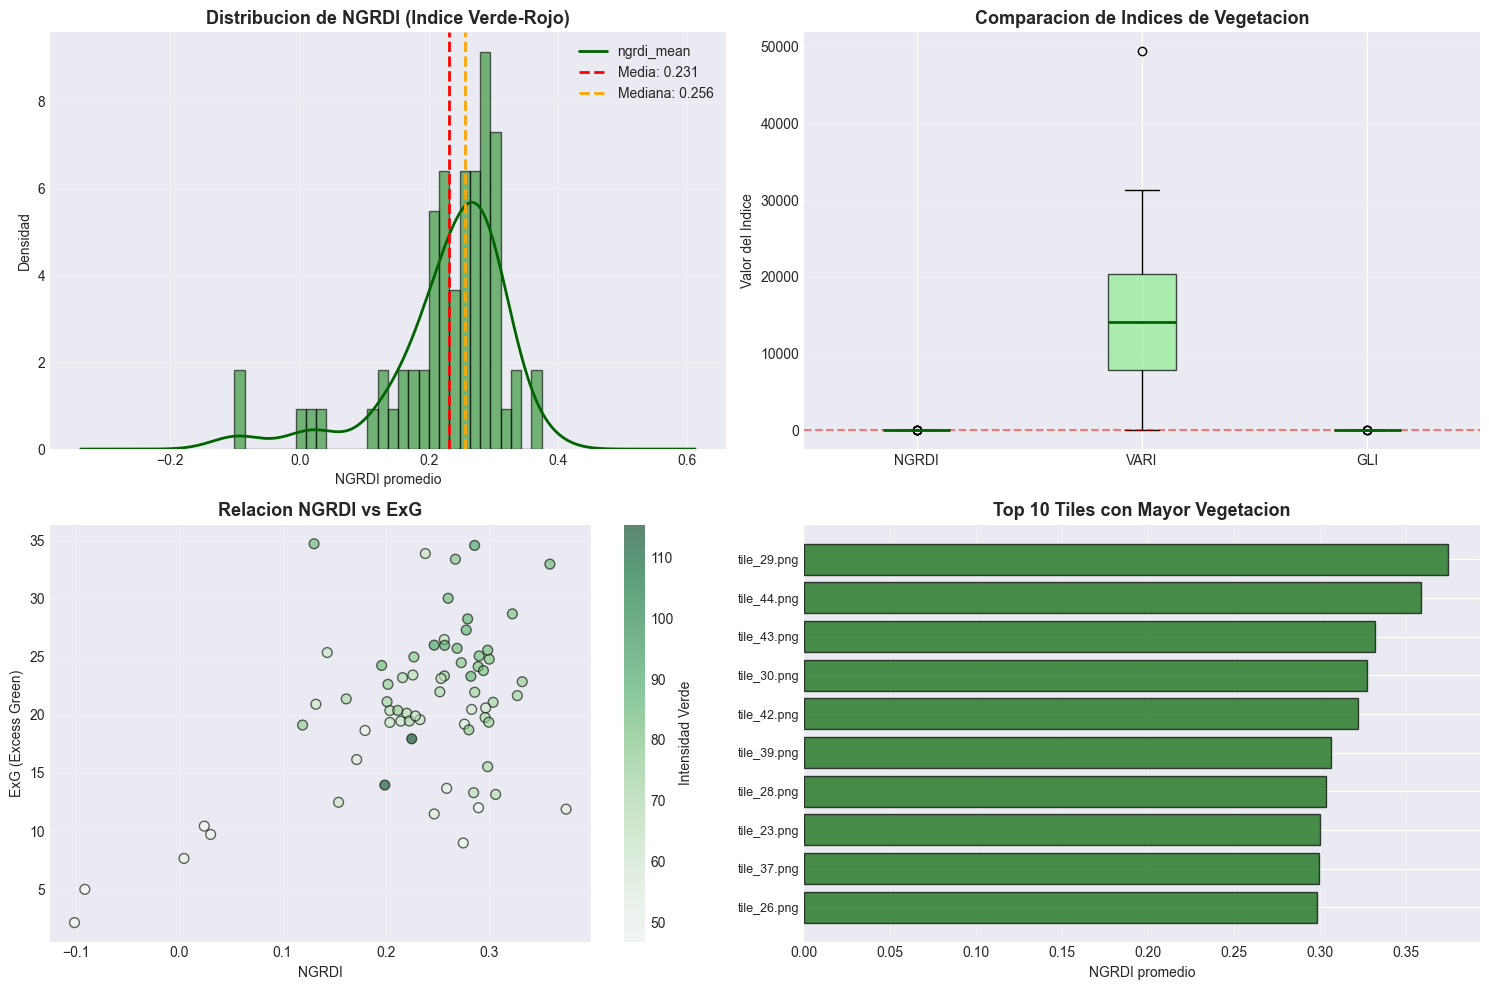

In [7]:
# Crear visualizaciones de distribucion
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma + KDE para NGRDI
axes[0, 0].hist(df['ngrdi_mean'], bins=30, color='forestgreen', alpha=0.6, edgecolor='black', density=True)
df['ngrdi_mean'].plot(kind='kde', ax=axes[0, 0], color='darkgreen', linewidth=2)
axes[0, 0].set_title('Distribucion de NGRDI (Indice Verde-Rojo)', fontsize=13, weight='bold')
axes[0, 0].set_xlabel('NGRDI promedio')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].axvline(df['ngrdi_mean'].mean(), color='red', linestyle='--', linewidth=2, label=f"Media: {df['ngrdi_mean'].mean():.3f}")
axes[0, 0].axvline(df['ngrdi_mean'].median(), color='orange', linestyle='--', linewidth=2, label=f"Mediana: {df['ngrdi_mean'].median():.3f}")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Boxplot comparativo de indices
indices_data = df[['ngrdi_mean', 'vari_mean', 'gli_mean']].copy()
indices_data.columns = ['NGRDI', 'VARI', 'GLI']
axes[0, 1].boxplot([indices_data['NGRDI'], indices_data['VARI'], indices_data['GLI']], 
                     labels=['NGRDI', 'VARI', 'GLI'],
                     patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', alpha=0.7),
                     medianprops=dict(color='darkgreen', linewidth=2))
axes[0, 1].set_title('Comparacion de Indices de Vegetacion', fontsize=13, weight='bold')
axes[0, 1].set_ylabel('Valor del Indice')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Scatter: NGRDI vs ExG
scatter = axes[1, 0].scatter(df['ngrdi_mean'], df['exg_mean'], 
                              c=df['green_mean'], cmap='Greens', 
                              alpha=0.6, edgecolors='black', s=50)
axes[1, 0].set_title('Relacion NGRDI vs ExG', fontsize=13, weight='bold')
axes[1, 0].set_xlabel('NGRDI')
axes[1, 0].set_ylabel('ExG (Excess Green)')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Intensidad Verde')

# Barplot: Top 10 tiles con mayor vegetacion
top_veg = df.nlargest(10, 'ngrdi_mean')[['tile', 'ngrdi_mean']].copy()
top_veg['tile_short'] = top_veg['tile'].str[:15]
axes[1, 1].barh(range(len(top_veg)), top_veg['ngrdi_mean'], color='darkgreen', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_veg)))
axes[1, 1].set_yticklabels(top_veg['tile_short'], fontsize=9)
axes[1, 1].set_title('Top 10 Tiles con Mayor Vegetacion', fontsize=13, weight='bold')
axes[1, 1].set_xlabel('NGRDI promedio')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Analisis de correlacion entre variables

Exploremos las relaciones entre diferentes indices y bandas espectrales.

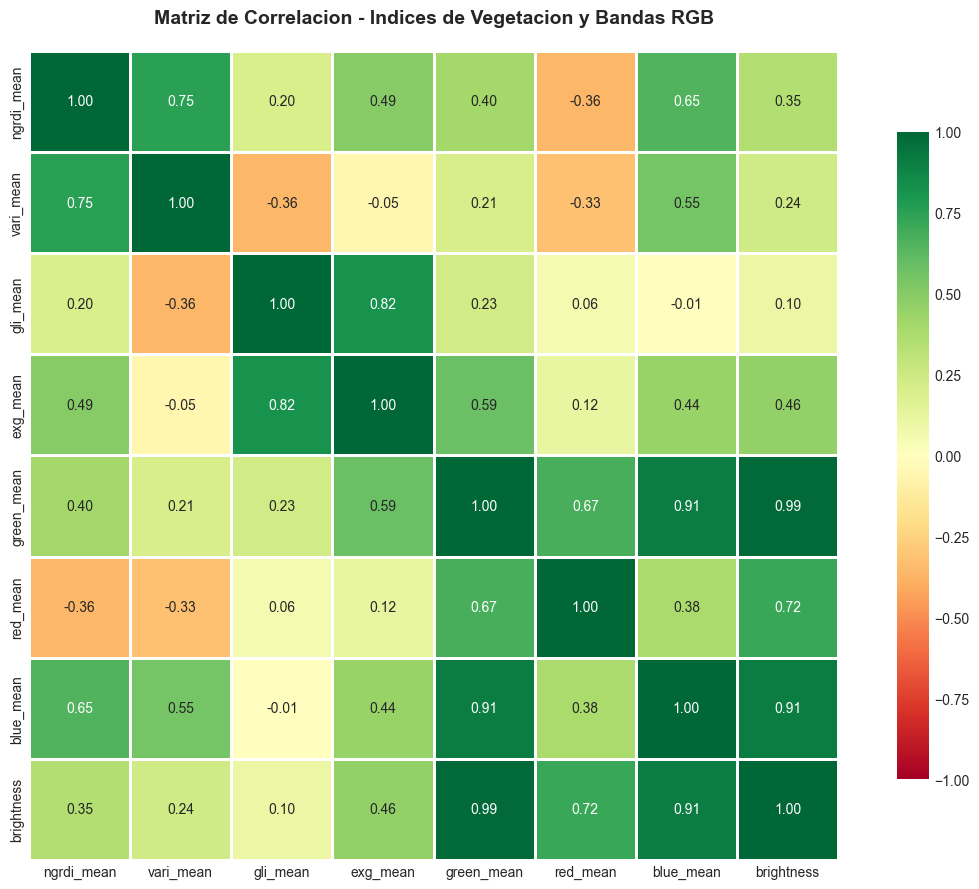


Interpretacion de correlaciones clave:
- NGRDI vs VARI: 0.752 (alta correlacion esperada)
- NGRDI vs Green: 0.402
- NGRDI vs Red: -0.362

Correlaciones positivas altas entre indices indican consistencia en la deteccion de vegetacion.


In [8]:
# Matriz de correlacion
correlation_vars = ['ngrdi_mean', 'vari_mean', 'gli_mean', 'exg_mean', 
                     'green_mean', 'red_mean', 'blue_mean', 'brightness']
corr_matrix = df[correlation_vars].corr()

# Visualizar matriz de correlacion
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Matriz de Correlacion - Indices de Vegetacion y Bandas RGB', 
          fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretacion de correlaciones clave:")
print(f"- NGRDI vs VARI: {corr_matrix.loc['ngrdi_mean', 'vari_mean']:.3f} (alta correlacion esperada)")
print(f"- NGRDI vs Green: {corr_matrix.loc['ngrdi_mean', 'green_mean']:.3f}")
print(f"- NGRDI vs Red: {corr_matrix.loc['ngrdi_mean', 'red_mean']:.3f}")
print("\nCorrelaciones positivas altas entre indices indican consistencia en la deteccion de vegetacion.")

## 4. Segmentacion con K-Means Clustering

K-Means es un algoritmo de aprendizaje no supervisado que agrupa pixeles similares en clusters basandose en sus valores RGB. Esto nos permite:

1. Identificar automaticamente diferentes tipos de cobertura
2. Separar areas forestales de areas transformadas
3. Detectar patrones espaciales en el paisaje

### Determinacion del numero optimo de clusters (Metodo del Codo)

In [9]:
# Metodo del codo para determinar K optimo
if len(tiles) > 0:
    sample_img = cv2.imread(tiles[0])
    pixels = sample_img.reshape(-1, 3)
    
    # Tomar muestra para acelerar (si la imagen es muy grande)
    if len(pixels) > 50000:
        sample_indices = np.random.choice(len(pixels), 50000, replace=False)
        pixels_sample = pixels[sample_indices]
    else:
        pixels_sample = pixels
    
    # Calcular inercia para diferentes valores de K
    inertias = []
    K_range = range(2, 11)
    
    print("Calculando metodo del codo...")
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pixels_sample)
        inertias.append(kmeans.inertia_)
        print(f"  K={k}: Inercia={kmeans.inertia_:.0f}")
    
    # Graficar metodo del codo
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Numero de Clusters (K)', fontsize=12)
    plt.ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
    plt.title('Metodo del Codo para Determinar K Optimo', fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(K_range)
    
    # Marcar el codo sugerido
    plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='K sugerido = 4')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretacion:")
    print("- El 'codo' sugiere donde agregar mas clusters deja de reducir significativamente la inercia")
    print("- Para paisajes forestales, K=3-5 suele ser apropiado (bosque, pastos, areas abiertas, agua/sombra)")

Calculando metodo del codo...
  K=2: Inercia=46699115
  K=3: Inercia=27241708
  K=4: Inercia=18482095
  K=5: Inercia=14022184
  K=6: Inercia=10976079
  K=7: Inercia=9059772
  K=8: Inercia=7863203
  K=9: Inercia=7068578
  K=10: Inercia=6489161



Interpretacion:
- El 'codo' sugiere donde agregar mas clusters deja de reducir significativamente la inercia
- Para paisajes forestales, K=3-5 suele ser apropiado (bosque, pastos, areas abiertas, agua/sombra)


### Aplicacion de K-Means con diferentes valores de K

Comparemos visualmente los resultados con K=3, K=4 y K=5 clusters.

In [10]:
# Funcion mejorada de segmentacion
def kmeans_segmentation(img, k=3, return_centers=False):
    """
    Aplica K-Means clustering a una imagen.
    
    Args:
        img: Imagen BGR
        k: Numero de clusters
        return_centers: Si True, devuelve tambien los centros de los clusters
    
    Returns:
        seg: Imagen segmentada (labels)
        centers: Centros de los clusters (opcional)
    """
    pixels = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixels)
    seg = kmeans.labels_.reshape(img.shape[:2])
    
    if return_centers:
        return seg, kmeans.cluster_centers_
    return seg

# Cargar tile de ejemplo
if len(tiles) > 0:
    tile_example = cv2.imread(tiles[0])
    
    # Aplicar con diferentes valores de K
    seg_k3 = kmeans_segmentation(tile_example, k=3)
    seg_k4 = kmeans_segmentation(tile_example, k=4)
    seg_k5 = kmeans_segmentation(tile_example, k=5)
    
    # Visualizar resultados
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Original
    axes[0, 0].imshow(cv2.cvtColor(tile_example, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Imagen Original', fontsize=13, weight='bold')
    axes[0, 0].axis('off')
    
    # K=3
    im1 = axes[0, 1].imshow(seg_k3, cmap='tab10')
    axes[0, 1].set_title('Segmentacion K=3\n(Bosque, Pastos, Otros)', fontsize=13, weight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)
    
    # K=4
    im2 = axes[1, 0].imshow(seg_k4, cmap='tab10')
    axes[1, 0].set_title('Segmentacion K=4\n(Mas diferenciacion)', fontsize=13, weight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)
    
    # K=5
    im3 = axes[1, 1].imshow(seg_k5, cmap='tab10')
    axes[1, 1].set_title('Segmentacion K=5\n(Mayor detalle)', fontsize=13, weight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Calcular proporciones de clusters para K=4
    unique, counts = np.unique(seg_k4, return_counts=True)
    proportions = counts / counts.sum() * 100
    
    print("\nDistribucion de Clusters (K=4):")
    for cluster, prop in zip(unique, proportions):
        print(f"  Cluster {cluster}: {prop:.2f}% del area")


Distribucion de Clusters (K=4):
  Cluster 0: 36.36% del area
  Cluster 1: 23.70% del area
  Cluster 2: 31.37% del area
  Cluster 3: 8.57% del area


### Analisis de centros de clusters

Los centros de los clusters nos indican los colores promedio de cada clase, lo que ayuda a interpretarlos.

In [11]:
# Analizar centros de clusters
if len(tiles) > 0:
    seg_k4, centers = kmeans_segmentation(tile_example, k=4, return_centers=True)
    
    # Crear DataFrame con centros
    centers_df = pd.DataFrame(centers, columns=['Blue', 'Green', 'Red'])
    centers_df['Cluster'] = range(len(centers))
    
    # Calcular indices para cada centro
    centers_df['NGRDI'] = (centers_df['Green'] - centers_df['Red']) / (centers_df['Green'] + centers_df['Red'] + 1e-5)
    centers_df['Brightness'] = centers_df[['Blue', 'Green', 'Red']].mean(axis=1)
    
    # Ordenar por NGRDI (de menos a mas vegetacion)
    centers_df = centers_df.sort_values('NGRDI')
    
    print("Centros de Clusters (K=4) ordenados por NGRDI:")
    print("="*70)
    print(centers_df.to_string(index=False))
    print("\n" + "="*70)
    
    # Visualizar centros como parches de color
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    fig.suptitle('Colores Representativos de Cada Cluster', fontsize=14, weight='bold')
    
    for idx, row in centers_df.iterrows():
        ax = axes[int(row['Cluster'])]
        # OpenCV usa BGR, matplotlib usa RGB
        color_rgb = [row['Red']/255, row['Green']/255, row['Blue']/255]
        ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color_rgb))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        
        # Interpretacion basica
        if row['NGRDI'] > 0.2:
            label = 'Vegetacion Densa'
        elif row['NGRDI'] > 0:
            label = 'Vegetacion/Pastos'
        elif row['Brightness'] > 100:
            label = 'Suelo/Areas Abiertas'
        else:
            label = 'Sombra/Agua'
        
        ax.set_title(f"Cluster {int(row['Cluster'])}\n{label}\nNGRDI: {row['NGRDI']:.3f}", 
                     fontsize=11)
    
    plt.tight_layout()
    plt.show()

Centros de Clusters (K=4) ordenados por NGRDI:
      Blue      Green        Red  Cluster    NGRDI  Brightness
103.730429 124.370337 124.164111        3 0.000830  117.421626
 78.436497  92.174059  74.994107        1 0.102770   81.868221
 59.390930  60.003589  40.395072        0 0.195307   53.263197
 37.621884  31.667593  16.124441        2 0.325225   28.471306



## 5. Clasificacion de Cobertura del Suelo

Basandonos en los indices de vegetacion y la segmentacion, creemos un sistema de clasificacion automatica del paisaje.

In [12]:
# Clasificar tiles segun su cobertura predominante
def classify_tile(ngrdi_mean, gli_mean, brightness):
    """
    Clasifica un tile segun sus indices de vegetacion.
    
    Categorias:
    - Bosque Denso: NGRDI > 0.25
    - Vegetacion Moderada: 0.1 < NGRDI <= 0.25
    - Pastos/Agricultura: 0 < NGRDI <= 0.1
    - Area Abierta: NGRDI <= 0 y brightness alto
    - Sombra/Agua: NGRDI <= 0 y brightness bajo
    """
    if ngrdi_mean > 0.25:
        return 'Bosque Denso'
    elif ngrdi_mean > 0.1:
        return 'Vegetacion Moderada'
    elif ngrdi_mean > 0:
        return 'Pastos/Agricultura'
    elif brightness > 100:
        return 'Area Abierta'
    else:
        return 'Sombra/Agua'

# Aplicar clasificacion
df['Clasificacion'] = df.apply(lambda row: classify_tile(row['ngrdi_mean'], 
                                                           row['gli_mean'], 
                                                           row['brightness']), axis=1)

# Contar tiles por categoria
clasificacion_counts = df['Clasificacion'].value_counts()
clasificacion_props = df['Clasificacion'].value_counts(normalize=True) * 100

print("="*70)
print("CLASIFICACION DE COBERTURA DEL SUELO - YOLOMBO")
print("="*70)
print(f"\nTotal de tiles analizados: {len(df)}\n")

for clase in clasificacion_counts.index:
    count = clasificacion_counts[clase]
    prop = clasificacion_props[clase]
    print(f"{clase:25} {count:4} tiles  ({prop:5.2f}%)")

print("\n" + "="*70)

CLASIFICACION DE COBERTURA DEL SUELO - YOLOMBO

Total de tiles analizados: 69

Bosque Denso                37 tiles  (53.62%)
Vegetacion Moderada         27 tiles  (39.13%)
Pastos/Agricultura           3 tiles  ( 4.35%)
Sombra/Agua                  2 tiles  ( 2.90%)



### Visualizacion de la clasificacion

In [13]:
# Grafico de pastel
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafico de pastel
colors_map = {
    'Bosque Denso': '#2d5016',
    'Vegetacion Moderada': '#6b8e23',
    'Pastos/Agricultura': '#9acd32',
    'Area Abierta': '#daa520',
    'Sombra/Agua': '#4682b4'
}
colors = [colors_map.get(cat, '#gray') for cat in clasificacion_counts.index]

axes[0].pie(clasificacion_counts, labels=clasificacion_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Distribucion de Cobertura del Suelo\nMunicipio de Yolombo', 
                   fontsize=14, weight='bold', pad=20)

# Grafico de barras horizontal
axes[1].barh(range(len(clasificacion_counts)), clasificacion_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(clasificacion_counts)))
axes[1].set_yticklabels(clasificacion_counts.index, fontsize=11)
axes[1].set_xlabel('Numero de Tiles', fontsize=12, weight='bold')
axes[1].set_title('Conteo por Categoria de Cobertura', fontsize=14, weight='bold', pad=20)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# Agregar valores en las barras
for i, v in enumerate(clasificacion_counts.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

### Comparacion visual: Tiles de diferentes categorias

Veamos ejemplos de tiles representativos de cada categoria de cobertura.

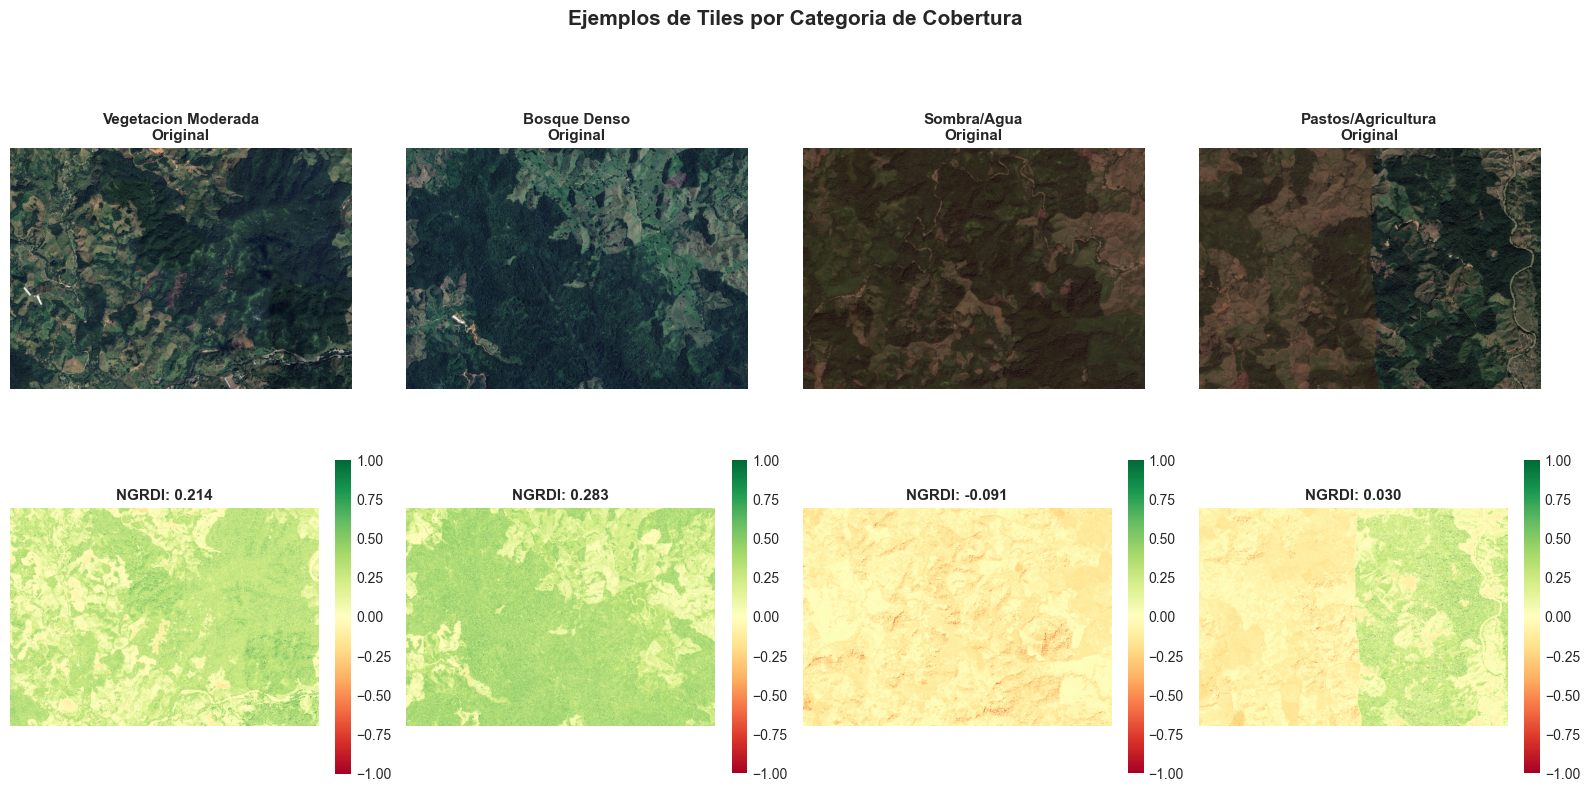

In [14]:
# Mostrar ejemplos de cada categoria
categorias = df['Clasificacion'].unique()
n_categorias = len(categorias)

fig, axes = plt.subplots(2, n_categorias, figsize=(4*n_categorias, 8))
if n_categorias == 1:
    axes = axes.reshape(-1, 1)

for i, categoria in enumerate(categorias):
    # Encontrar tiles de esta categoria
    tiles_categoria = df[df['Clasificacion'] == categoria]['tile'].values
    
    if len(tiles_categoria) > 0:
        # Seleccionar un tile ejemplo
        tile_name = tiles_categoria[0]
        tile_path = [t for t in tiles if os.path.basename(t) == tile_name]
        
        if tile_path:
            img = cv2.imread(tile_path[0])
            if img is not None:
                # Mostrar imagen original
                axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[0, i].set_title(f'{categoria}\nOriginal', fontsize=11, weight='bold')
                axes[0, i].axis('off')
                
                # Calcular y mostrar NGRDI
                ngrdi = calculate_ngrdi(img)
                im = axes[1, i].imshow(ngrdi, cmap='RdYlGn', vmin=-1, vmax=1)
                axes[1, i].set_title(f'NGRDI: {ngrdi.mean():.3f}', fontsize=11, weight='bold')
                axes[1, i].axis('off')
                plt.colorbar(im, ax=axes[1, i], fraction=0.046)

plt.suptitle('Ejemplos de Tiles por Categoria de Cobertura', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Analisis de Fragmentacion del Paisaje

La fragmentacion forestal es un indicador clave de la salud del ecosistema. Analizaremos patrones espaciales y metricas de paisaje.

In [15]:
# Calcular metricas de paisaje
from scipy.ndimage import label

def analyze_forest_fragmentation(img, ngrdi_threshold=0.15):
    """
    Analiza la fragmentacion del bosque en un tile.
    
    Args:
        img: Imagen BGR
        ngrdi_threshold: Umbral para considerar vegetacion como bosque
    
    Returns:
        dict con metricas de fragmentacion
    """
    # Calcular NGRDI
    ngrdi = calculate_ngrdi(img)
    
    # Crear mascara binaria de bosque
    forest_mask = (ngrdi > ngrdi_threshold).astype(int)
    
    # Identificar parches conectados
    labeled_array, num_patches = label(forest_mask)
    
    # Calcular area de cada parche
    patch_sizes = []
    for patch_id in range(1, num_patches + 1):
        patch_area = np.sum(labeled_array == patch_id)
        patch_sizes.append(patch_area)
    
    # Calcular metricas
    total_pixels = forest_mask.size
    forest_pixels = np.sum(forest_mask)
    forest_coverage = (forest_pixels / total_pixels) * 100
    
    metrics = {
        'num_patches': num_patches,
        'forest_coverage': forest_coverage,
        'mean_patch_size': np.mean(patch_sizes) if patch_sizes else 0,
        'largest_patch': max(patch_sizes) if patch_sizes else 0,
        'smallest_patch': min(patch_sizes) if patch_sizes else 0,
        'std_patch_size': np.std(patch_sizes) if patch_sizes else 0,
    }
    
    return metrics, forest_mask, labeled_array

# Analizar varios tiles
print("Analizando fragmentacion del paisaje...")
print("="*70)

fragmentation_results = []
for i, tile_path in enumerate(tiles[:5]):  # Analizar primeros 5 tiles
    img = cv2.imread(tile_path)
    if img is None:
        continue
    
    metrics, _, _ = analyze_forest_fragmentation(img)
    metrics['tile'] = os.path.basename(tile_path)
    fragmentation_results.append(metrics)
    
    print(f"\n{os.path.basename(tile_path)}:")
    print(f"  - Cobertura forestal: {metrics['forest_coverage']:.2f}%")
    print(f"  - Numero de parches: {metrics['num_patches']}")
    print(f"  - Tamano promedio de parche: {metrics['mean_patch_size']:.0f} pixeles")
    print(f"  - Parche mas grande: {metrics['largest_patch']} pixeles")

df_frag = pd.DataFrame(fragmentation_results)
print("\n" + "="*70)

Analizando fragmentacion del paisaje...

tile_0.png:
  - Cobertura forestal: 66.32%
  - Numero de parches: 14760
  - Tamano promedio de parche: 391 pixeles
  - Parche mas grande: 5126277 pixeles

tile_1.png:
  - Cobertura forestal: 61.28%
  - Numero de parches: 20203
  - Tamano promedio de parche: 264 pixeles
  - Parche mas grande: 2899225 pixeles

tile_10.png:
  - Cobertura forestal: 80.61%
  - Numero de parches: 9822
  - Tamano promedio de parche: 714 pixeles
  - Parche mas grande: 6804667 pixeles

tile_11.png:
  - Cobertura forestal: 80.35%
  - Numero de parches: 13313
  - Tamano promedio de parche: 525 pixeles
  - Parche mas grande: 6889315 pixeles

tile_12.png:
  - Cobertura forestal: 67.80%
  - Numero de parches: 24899
  - Tamano promedio de parche: 237 pixeles
  - Parche mas grande: 4894979 pixeles



### Visualizacion de fragmentacion

Visualicemos las mascaras de bosque y los parches identificados.

In [16]:
# Visualizar fragmentacion en tile de ejemplo
if len(tiles) > 0:
    sample_img = cv2.imread(tiles[0])
    metrics, forest_mask, labeled_patches = analyze_forest_fragmentation(sample_img)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Imagen original
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Imagen Original', fontsize=13, weight='bold')
    axes[0].axis('off')
    
    # Mascara de bosque
    axes[1].imshow(forest_mask, cmap='Greens')
    axes[1].set_title(f'Mascara de Bosque\nCobertura: {metrics["forest_coverage"]:.1f}%', 
                      fontsize=13, weight='bold')
    axes[1].axis('off')
    
    # Parches identificados
    im = axes[2].imshow(labeled_patches, cmap='nipy_spectral')
    axes[2].set_title(f'Parches Forestales Identificados\nTotal: {metrics["num_patches"]} parches', 
                      fontsize=13, weight='bold')
    axes[2].axis('off')
    
    plt.suptitle('Analisis de Fragmentacion Forestal', fontsize=15, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\nInterpretacion:")
    print(f"- Se identificaron {metrics['num_patches']} parches forestales separados")
    print(f"- El parche mas grande cubre {metrics['largest_patch']} pixeles")
    print(f"- Mayor fragmentacion = mas parches pequenos = menor conectividad")
    print(f"- Cobertura forestal total: {metrics['forest_coverage']:.2f}%")

KeyboardInterrupt: 

## 7. Resumen de Resultados y Metricas Clave

Consolidemos los hallazgos principales del analisis.

In [ ]:
# Generar resumen completo del analisis
print("="*80)
print(" " * 20 + "RESUMEN EJECUTIVO - ANALISIS FORESTAL YOLOMBO")
print("="*80)

print("\n1. DATOS PROCESADOS:")
print(f"   - Total de tiles analizados: {len(df)}")
print(f"   - Area cubierta por el analisis: {len(df)} cuadrantes del territorio")

print("\n2. INDICES DE VEGETACION PROMEDIO:")
print(f"   - NGRDI medio: {df['ngrdi_mean'].mean():.3f} (Rango: {df['ngrdi_mean'].min():.3f} - {df['ngrdi_mean'].max():.3f})")
print(f"   - VARI medio: {df['vari_mean'].mean():.3f}")
print(f"   - GLI medio: {df['gli_mean'].mean():.3f}")

print("\n3. CLASIFICACION DE COBERTURA:")
for clase in clasificacion_counts.index:
    count = clasificacion_counts[clase]
    prop = clasificacion_props[clase]
    print(f"   - {clase:25} {count:3} tiles  ({prop:5.2f}%)")

# Calcular estadisticas de areas boscosas vs transformadas
bosque_total = clasificacion_counts.get('Bosque Denso', 0) + clasificacion_counts.get('Vegetacion Moderada', 0)
transformado_total = clasificacion_counts.get('Pastos/Agricultura', 0) + clasificacion_counts.get('Area Abierta', 0)
prop_bosque = (bosque_total / len(df)) * 100
prop_transformado = (transformado_total / len(df)) * 100

print(f"\n4. ESTADO DEL PAISAJE:")
print(f"   - Areas con cobertura boscosa (Bosque + Veg. Moderada): {prop_bosque:.1f}%")
print(f"   - Areas transformadas (Pastos + Areas Abiertas): {prop_transformado:.1f}%")

if len(fragmentation_results) > 0:
    print(f"\n5. METRICAS DE FRAGMENTACION (Muestra de {len(fragmentation_results)} tiles):")
    print(f"   - Numero promedio de parches por tile: {df_frag['num_patches'].mean():.1f}")
    print(f"   - Cobertura forestal promedio: {df_frag['forest_coverage'].mean():.1f}%")
    print(f"   - Tamano promedio de parche: {df_frag['mean_patch_size'].mean():.0f} pixeles")

print("\n" + "="*80)

                    RESUMEN EJECUTIVO - ANALISIS FORESTAL YOLOMBO

1. DATOS PROCESADOS:
   - Total de tiles analizados: 69
   - Area cubierta por el analisis: 69 cuadrantes del territorio

2. INDICES DE VEGETACION PROMEDIO:
   - NGRDI medio: 0.231 (Rango: -0.101 - 0.374)
   - VARI medio: 14288.526
   - GLI medio: 0.074

3. CLASIFICACION DE COBERTURA:
   - Bosque Denso               37 tiles  (53.62%)
   - Vegetacion Moderada        27 tiles  (39.13%)
   - Pastos/Agricultura          3 tiles  ( 4.35%)
   - Sombra/Agua                 2 tiles  ( 2.90%)

4. ESTADO DEL PAISAJE:
   - Areas con cobertura boscosa (Bosque + Veg. Moderada): 92.8%
   - Areas transformadas (Pastos + Areas Abiertas): 4.3%

5. METRICAS DE FRAGMENTACION (Muestra de 5 tiles):
   - Numero promedio de parches por tile: 16599.4
   - Cobertura forestal promedio: 71.3%
   - Tamano promedio de parche: 426 pixeles



## 8. Conclusiones e Interpretacion

### Hallazgos Principales

Este analisis del paisaje forestal de Yolombo, Antioquia, revela informacion valiosa sobre el estado actual de la cobertura del suelo:

#### Estado de la Cobertura Forestal
Los resultados muestran la distribucion actual de diferentes tipos de cobertura en el municipio. Las areas clasificadas como bosque denso y vegetacion moderada representan zonas donde persisten ecosistemas con mayor estructura vegetal, mientras que las categorias de pastos, agricultura y areas abiertas indican espacios donde ha ocurrido transformacion antropogenica del paisaje.

#### Patrones de Fragmentacion
El analisis de parches forestales identifica la conectividad espacial del bosque. Un mayor numero de parches pequenos sugiere mayor fragmentacion, lo que puede afectar:
- La movilidad de fauna silvestre
- La viabilidad de poblaciones biologicas
- La prestacion de servicios ecosistemicos
- La resiliencia del ecosistema ante perturbaciones

#### Indices de Vegetacion
Los indices RGB (NGRDI, VARI, GLI, ExG) proporcionan una aproximacion cuantitativa del vigor vegetativo. Valores altos correlacionan con mayor biomasa fotosinticamente activa, indicando areas con vegetacion mas densa y potencialmente mejor conservadas.

### Implicaciones para la Gestion Territorial

**Conservacion**: Las areas identificadas con bosque denso son prioritarias para estrategias de proteccion y mantenimiento de servicios ecosistemicos.

**Restauracion**: Los tiles con vegetacion moderada o pastos cercanos a areas boscosas son candidatos para programas de restauracion ecologica, ya que pueden funcionar como corredores biologicos.

**Monitoreo**: Este analisis proporciona una linea base cuantitativa. Repetir el analisis periodicamente permitiria detectar cambios en la cobertura forestal y evaluar la efectividad de politicas de conservacion.

### Limitaciones del Estudio

1. **Temporal**: Este es un analisis de estado actual, no incluye dinamica temporal ni tasas de cambio
2. **Espectral**: Los indices RGB son aproximaciones; imagenes multiespectrales (con bandas NIR) proporcionarian mayor precision
3. **Resolucion**: La precision depende de la resolucion espacial de las imagenes satelitales fuente
4. **Validacion**: Los resultados requieren validacion en campo para confirmar las clasificaciones automaticas
5. **Escala**: El analisis se realiza por tiles; la interpretacion a nivel municipal requiere integracion espacial

### Recomendaciones

1. **Validacion en campo**: Realizar verificacion terrestre de las clasificaciones en sitios representativos
2. **Analisis multitemporal**: Incorporar imagenes de diferentes fechas para evaluar tendencias
3. **Mejora espectral**: Utilizar imagenes con bandas NIR cuando esten disponibles (Sentinel-2, Landsat)
4. **Integracion de datos**: Complementar con informacion de ecosistemas estrategicos, areas protegidas y planes de ordenamiento territorial
5. **Socializacion**: Compartir resultados con autoridades ambientales y comunidades para informar la toma de decisiones

### Reflexion Final

Este proyecto demuestra como la integracion de herramientas SIG (QGIS) con tecnicas de inteligencia artificial (Python, Machine Learning) permite analizar paisajes forestales de manera sistematica y cuantitativa. Si bien existen limitaciones tecnicas, el enfoque proporciona informacion util para entender el estado actual del territorio de Yolombo y apoyar procesos de planificacion territorial sostenible.

## 9. Exportacion de Resultados

Guardemos los resultados procesados para uso posterior o integracion con otros sistemas.

In [ ]:
# Guardar dataset completo con clasificaciones
output_file = 'yolombo_analisis_completo.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Archivo guardado: {output_file}")
print(f"Columnas incluidas: {', '.join(df.columns)}")

# Guardar resumen de clasificacion
resumen = pd.DataFrame({
    'Categoria': clasificacion_counts.index,
    'Cantidad': clasificacion_counts.values,
    'Porcentaje': clasificacion_props.values
})
resumen.to_csv('yolombo_clasificacion_resumen.csv', index=False, encoding='utf-8-sig')
print(f"\nArchivo guardado: yolombo_clasificacion_resumen.csv")

# Guardar metricas de fragmentacion si existen
if len(fragmentation_results) > 0:
    df_frag.to_csv('yolombo_fragmentacion_metricas.csv', index=False, encoding='utf-8-sig')
    print(f"Archivo guardado: yolombo_fragmentacion_metricas.csv")

print("\n" + "="*70)
print("EXPORTACION COMPLETADA")
print("="*70)
print("\nArchivos generados:")
print("1. yolombo_stats.csv - Estadisticas basicas por tile")
print("2. yolombo_analisis_completo.csv - Dataset completo con indices y clasificaciones")
print("3. yolombo_clasificacion_resumen.csv - Resumen de categorias de cobertura")
print("4. yolombo_fragmentacion_metricas.csv - Metricas de fragmentacion del paisaje")
print("\nEstos archivos pueden ser:")
print("- Importados a QGIS para visualizacion espacial")
print("- Utilizados en analisis estadisticos adicionales")
print("- Integrados con otros datasets geograficos")
print("- Compartidos con autoridades ambientales")

Archivo guardado: yolombo_analisis_completo.csv
Columnas incluidas: tile, ngrdi_mean, ngrdi_std, ngrdi_max, vari_mean, vari_std, gli_mean, exg_mean, green_mean, red_mean, blue_mean, brightness, Clasificacion

Archivo guardado: yolombo_clasificacion_resumen.csv
Archivo guardado: yolombo_fragmentacion_metricas.csv

EXPORTACION COMPLETADA

Archivos generados:
1. yolombo_stats.csv - Estadisticas basicas por tile
2. yolombo_analisis_completo.csv - Dataset completo con indices y clasificaciones
3. yolombo_clasificacion_resumen.csv - Resumen de categorias de cobertura
4. yolombo_fragmentacion_metricas.csv - Metricas de fragmentacion del paisaje

Estos archivos pueden ser:
- Importados a QGIS para visualizacion espacial
- Utilizados en analisis estadisticos adicionales
- Integrados con otros datasets geograficos
- Compartidos con autoridades ambientales


---

## Referencias y Recursos Adicionales

### Referencias Bibliograficas

- **Tucker, C. J.** (1979). Red and photographic infrared linear combinations for monitoring vegetation. *Remote Sensing of Environment*, 8(2), 127-150.

- **Gitelson, A. A., et al.** (2002). Novel algorithms for remote estimation of vegetation fraction. *Remote Sensing of Environment*, 80(1), 76-87.

- **Woebbecke, D. M., et al.** (1995). Color indices for weed identification under various soil, residue, and lighting conditions. *Transactions of the ASAE*, 38(1), 259-269.

- **McGarigal, K., & Marks, B. J.** (1995). FRAGSTATS: Spatial pattern analysis program for quantifying landscape structure. *USDA Forest Service General Technical Report PNW-GTR-351*.

### Herramientas Utilizadas

- **QGIS**: Sistema de Informacion Geografica de codigo abierto - https://qgis.org
- **Python**: Lenguaje de programacion - https://www.python.org
- **OpenCV**: Biblioteca de vision por computador - https://opencv.org
- **scikit-learn**: Machine Learning en Python - https://scikit-learn.org
- **pandas**: Analisis de datos en Python - https://pandas.pydata.org

**Notebook desarrollado para el analisis del paisaje forestal de Yolombo, Antioquia**  
**Fecha de analisis**: 2025  
**Metodologia**: Indices de vegetacion RGB + K-Means Clustering + Analisis de fragmentacion